In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym
import numpy as np
import tensorflow as tf

In [16]:
first_layer = 8 
epsilon = 0.01 # stddev for initial randomized weights
learning_rate = 0.5
threshold = 50 # initial threshold for a good episode

In [17]:
# network
# input, fake labels, advantage
x = tf.placeholder(tf.float32, [None, 4])
y_ = tf.placeholder(tf.float32, [None, 2]) # fake labels, up or down action
a_ = tf.placeholder(tf.float32, [None]) # advantage

# first layer
w1 = tf.Variable(tf.random_normal([4, first_layer], stddev=epsilon))
b1 = tf.Variable(tf.zeros([first_layer]))
z1 = tf.matmul(x, w1) + b1
a1 = tf.nn.tanh(z1)

# output layer
w2 = tf.Variable(tf.random_normal([first_layer, 2], stddev=epsilon))
b2 = tf.Variable(tf.zeros([2]))
z2 = tf.matmul(a1, w2) + b2
y = tf.nn.softmax(z2)

cost = tf.reduce_mean(a_ * tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=z2))
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [18]:
def get_action(observation):
    prob = sess.run(y, feed_dict={x: np.reshape(observation, [1,4])})[0]
    action = np.random.choice((0,1), p=prob)
    return action

In [19]:
def play_episode():
    observation = env.reset()
    ep_obs = [] # list of observations
    ep_acts = [] # list of actions
    while True:
        #if render: env.render()
        # get action
        action = get_action(observation)
        
        # append observations and actions
        ep_obs.append(observation)        
        ep_acts.append(action)
        
        # perform action
        observation, reward, done, info = env.step(action)
        
        if done:
            return ep_obs, ep_acts

In [20]:
def play_batch(n_episodes):
    batch_obs = [] # list of lists of observations
    batch_acts = [] # list of lists of actions
    for i in range(n_episodes):
        ep_obs, ep_acts = play_episode()
        batch_obs.append(ep_obs)
        batch_acts.append(ep_acts)
    return batch_obs, batch_acts

In [21]:
# initialize tensor flow
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [22]:
# pre-training monitoring
#env = gym.make('CartPole-v0')
#env = gym.wrappers.Monitor(env, './pre-training', force=True,)
# force=True clears previous monitor files
#print('pre-training')
#for i in range(10):
#    a, b = play_episode()
#    print(len(b))

In [28]:
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, './training', force=True,)
# force=True clears previous monitor files
# training
averages = []
batch_size = 20
iterations = 500
threshold = 50
render = False
print('training')
for i in range(iterations):
    batch_obs, batch_acts = play_batch(batch_size)
    xs = [] # list of n_moves x 4 arrays
    y_s = [] # list of n_moves x 2 array
    a_s = [] # list of n_moves sized array

    # get average length of episode
    average = 0
    for a in batch_acts:
        average += len(a)
    average /= batch_size
    
    # change threshold to increase standards
    if average > threshold:
        threshold = average

    # number of good episodes
    #good_eps = 0

    for ep_obs, ep_acts in zip(batch_obs, batch_acts):
        n_moves = len(ep_acts)

        if n_moves > threshold:
            #good_eps += 1

            # observations
            xs.append(np.stack(ep_obs))

            # encode the move we made
            move = np.zeros([n_moves, 2])
            move[range(n_moves), ep_acts] = 1 # ep_act is either 0 or 1, we make this index 1
            y_s.append(move)

            # advantages
            adv = np.ones([n_moves])
            a_s.append(adv)
    
    averages.append(average)
    if len(a_s) > 0:
        train_x = np.concatenate(xs)
        train_y_ = np.concatenate(y_s)
        train_a_ = np.concatenate(a_s)
        sess.run(train, feed_dict={x: train_x, y_: train_y_, a_: train_a_})
        print(i, average)
        #print('Updated with',good_eps, 'episodes')
    else:
        None
        # print('All episodes in this batch sucked!!!')

[2017-06-18 12:07:07,864] Making new env: CartPole-v0
[2017-06-18 12:07:07,953] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/Adam/Dropbox/AI/Cart Pole/training')
[2017-06-18 12:07:07,960] Clearing 42 monitor files from previous run (because force=True was provided)
[2017-06-18 12:07:07,968] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/training/openaigym.video.6.4491.video000000.mp4


training


[2017-06-18 12:07:10,806] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/training/openaigym.video.6.4491.video000001.mp4
[2017-06-18 12:07:13,585] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/training/openaigym.video.6.4491.video000008.mp4


0 199.05


[2017-06-18 12:07:16,935] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/training/openaigym.video.6.4491.video000027.mp4


1 190.15


[2017-06-18 12:07:22,129] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/training/openaigym.video.6.4491.video000064.mp4


KeyboardInterrupt: 

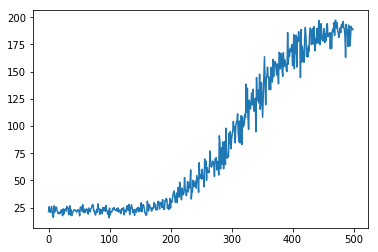

In [10]:
plt.plot(averages)
plt.savefig('./averages.png')

In [11]:
# post-training monitoring
#env = gym.make('CartPole-v0')
#env = gym.wrappers.Monitor(env, './post-training', force=True)
# force=True clears previous monitor files
#print('post-training')
#for i in range(10):
#    a, b = play_episode()
#    print(len(b))

[2017-06-18 11:43:05,729] Making new env: CartPole-v0
[2017-06-18 11:43:05,738] Creating monitor directory ./post-training
[2017-06-18 11:43:05,744] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/post-training/openaigym.video.1.4491.video000000.mp4


post-training


[2017-06-18 11:43:08,244] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/post-training/openaigym.video.1.4491.video000001.mp4


181
104
200
200
200
180
200


[2017-06-18 11:43:10,172] Starting new video recorder writing to /Users/Adam/Dropbox/AI/Cart Pole/post-training/openaigym.video.1.4491.video000008.mp4


200
200
200
